# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

# 2. Import Packages

In [513]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
import missingno as msno
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from collections import defaultdict
from datetime import datetime

# 3. Objectives of This Notebook

- To determine if the data we have could be use to develop a pricing model
    - Verify that there is an appropriate target feature
    - Verify that there are potentially useful features
- Verify that there are not fundamental issues with the data

# 4. Loading Data

In [514]:
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [515]:
rentals = immo_data.copy()

In [516]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [517]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [518]:
rentals.shape

(268850, 49)

- We observe that the dataframe has 49 features associated with 268,850 apartment records that have been put up for rent. 
- We note that there are various price-related features that will be examined to determine the appropriate target feature. For instance, we need to choose between totalRent and baseRent. Furthermore, we neet to determin the relationships between such features as heatingCosts and the possible target features of totalRent and baseRent.
- The dataframe features comprise of 4 main datatypes, including 6 boolean, 18 float, 6 integer and 19 object datatypes. We would need to verfiy that these datatypes are accurate in the context of our goal of developing a price model for rent. We also note a varying level of quality associated with each feature in terms of how many records exist for the particular feature. We would need to deal with those features that have a lot of empty values. 
- Finally, we observe that the amount of memory used up by the dataframe is ~89, which is manageable. Higher capacity data-processing cloud computing technologies may not be necessary.

# 5. Reviewing the Data 

## 5.1 Checking For Duplicates

- We will check for duplicated information for apartment addresses. 
- We will check duplicates across regio1, regio2, regio3, street, and houseNumber

In [519]:
#Check for duplicated rows across features
rentals.duplicated(['regio1','regio2', 'regio3', 'street', 'houseNumber']).sum()

115338

In [520]:
#Determine nature of duplicates
duplicated = rentals.loc[rentals.duplicated(['regio1','regio2', 'regio3', 'street', 'houseNumber']), ['regio1','regio2', 'regio3', 'street', 'houseNumber']]

In [521]:
duplicated.head()

,regio1,regio2,regio3,street,houseNumber
148,Hessen,Main_Kinzig_Kreis,Hanau,no_information,NaN
317,Sachsen,Vogtlandkreis,Reichenbach_im_Vogtland,no_information,NaN
359,Sachsen_Anhalt,Harz_Kreis,Quedlinburg,no_information,NaN
366,Nordrhein_Westfalen,Rheinisch_Bergischer_Kreis,Bergisch_Gladbach,no_information,NaN
396,Hessen,Main_Kinzig_Kreis,Hanau,no_information,NaN


- We notice that many rows have missing street and houseNumber information and likely contributes to the number of missing values
- We will filter the duplicated dataframe to exclude this null entries to see if there other sources of duplicated rows

In [522]:
#Filter-out rows where street and houseNumber have missing values
duplicated_nomissing = duplicated[(duplicated.street != 'no_information') & (duplicated.houseNumber.isna())]

In [523]:
duplicated_nomissing.shape[0]

0

- We have established that the only duplicated records apply to addresses that have no street or houseNumber information.

## 5.2 Reviewing Data Completeness

In [524]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['Count', '%age total']
missing.sort_values(by = 'Count', ascending = False)

,Count,%age total
telekomHybridUploadSpeed,223830,83.254603
electricityKwhPrice,222004,82.575414
electricityBasePrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188139,69.979171
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


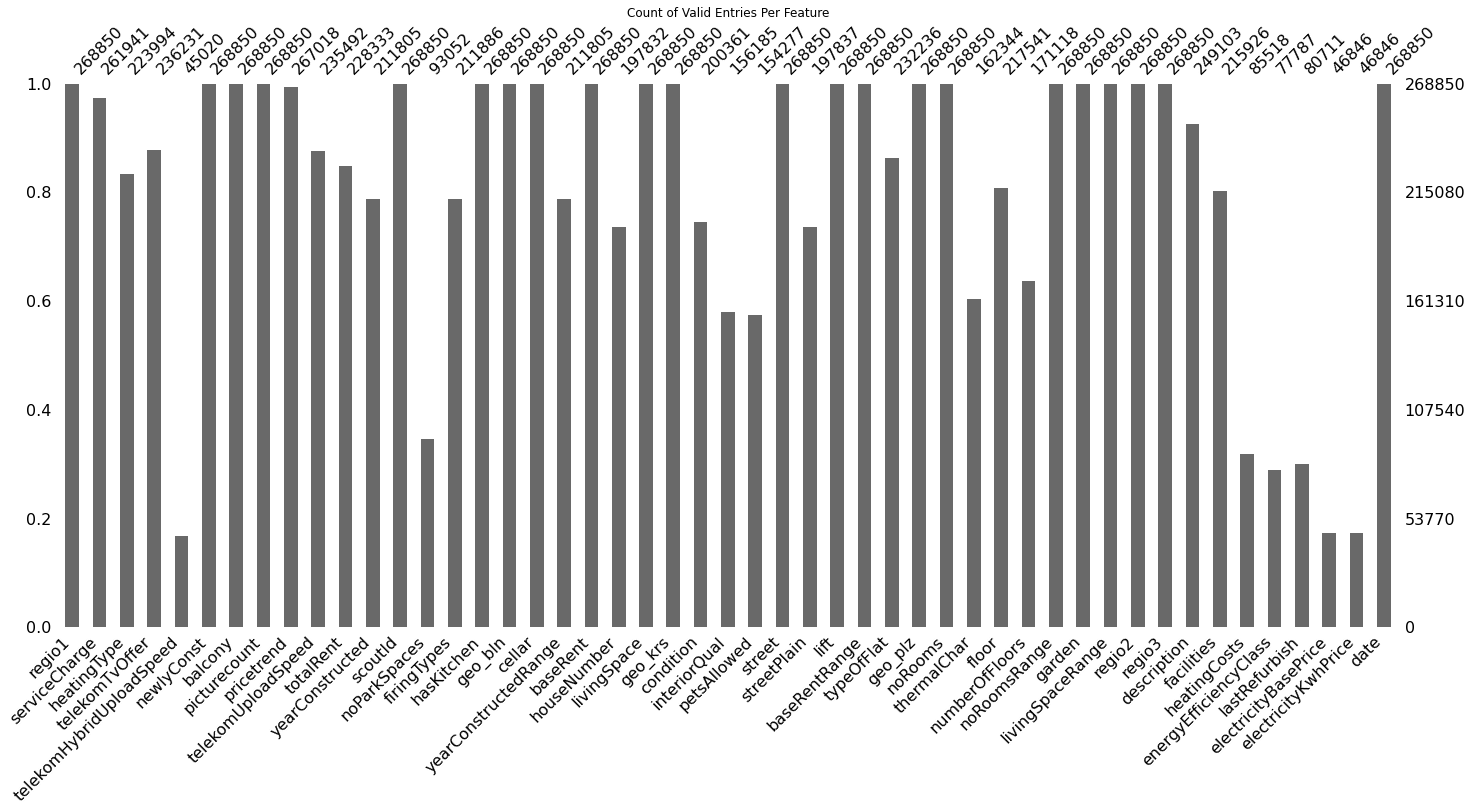

In [525]:
#Show the prescence on non-null values as a bar chart
_= msno.bar(rentals)
_= plt.title('Count of Valid Entries Per Feature')

- We notice that some features have many missing values. We will select features that have 60% valid entries into our dataframe.

In [526]:
#Filter-out features with over 40% missing values
rentals = msno.nullity_filter(rentals,filter = 'top', p =0.6)

In [527]:
rentals.shape

(268850, 40)

In [528]:
rentals.head(2)

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,date
0,Nordrhein_Westfalen,245.0,central_heating,ONE_YEAR_FREE,False,False,6,4.62,10.0,840.0,1965.0,96107057,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.0,Dortmund,well_kept,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,May19
1,Rheinland_Pfalz,134.0,self_contained_central_heating,ONE_YEAR_FREE,False,True,8,3.47,10.0,NaN,1871.0,111378734,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.0,Rhein_Pfalz_Kreis,refurbished,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,May19


## 5.3 Reviewing Categorical Features

### 5.3.1 Reviewing Categorical Features with Missing Values 

In [529]:
#Features with missing values
mssgCols = rentals.columns[rentals.isna().any()]

In [530]:
#Categorical features with missing values
mssgCat = rentals[mssgCols].select_dtypes('object')

In [531]:
mssgCat.head(2)

,heatingType,telekomTvOffer,firingTypes,houseNumber,condition,streetPlain,typeOfFlat,description,facilities
0,central_heating,ONE_YEAR_FREE,oil,244,well_kept,Schüruferstraße,ground_floor,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...
1,self_contained_central_heating,ONE_YEAR_FREE,gas,NaN,refurbished,NaN,ground_floor,Alles neu macht der Mai – so kann es auch für ...,NaN


In [532]:
mssgCat.describe()

,heatingType,telekomTvOffer,firingTypes,houseNumber,condition,streetPlain,typeOfFlat,description,facilities
count,223994,236231,211886,197832,200361,197837,232236,249103,215926
unique,13,3,132,5510,10,54490,10,212621,189526
top,central_heating,ONE_YEAR_FREE,gas,1,well_kept,Hauptstraße,apartment,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat
freq,128977,227632,110899,7173,66591,911,131522,216,207


- First, we notice that firingTypes (132), houseNumber(5510), streetPlain(54490), description (212621) and facilities (189526) have a lot of categories. We can take a closer look at these. 

In [533]:
mssgCat[['firingTypes','houseNumber', 'streetPlain','description','facilities']].sample(20)

,firingTypes,houseNumber,streetPlain,description,facilities
76069,NaN,NaN,NaN,Diese ansprechende Dachgeschosswohnung in der ...,NaN
59865,gas,NaN,NaN,"Mitten in der City von Gehrden entsteht der ""G...",Hell und modern zeichnet diese Immobilien aus!...
170009,gas,4,Astrid-Lindgren-Platz,Das Mehrfamilienhaus wurde im skandinavischen ...,"• Wohnraum 1\n• Schlafraum, 1\n• Terr..."
49725,gas,42,Brenderweg,"Die moderne 3,5 ZKB Wohnung liegt in einem ren...",Moderne Ausstattung.\n\nBalkon mit herrlicher ...
63864,district_heating,16,Leifringhauser_Straße,Die gut geschnittene 2-Zimmer Wohnung befindet...,NaN
2894,gas,21,Winklerstraße_,Schöne helle Wohnung in kernsaniertem Gründerz...,- moderne Isolierglasfenster\n- ansprechende B...
61497,oil,1a,Alte_Straße,Das Objekt wird von sehr angenehmen Mietern be...,Die Wohneinheit verfügt über 3 Zimmer. Die Ges...
129432,district_heating,103,Lübecker_Straße,Im Wohnbereich befinden sich auf 2 Etagen insg...,Ihr neues Apartment ist in einem sehr guten Zu...
114277,gas,157,Eichenstraße,Das Objekt auf der Eichenstraße besteht aus 8 ...,Die 2-Zimmer-Wohnung verfügt über einen großen...
132334,gas,NaN,NaN,Vermiete ab sofort sonnige Dachwohnung in Thum.,Die Wohnung hat nachfolgende Ausstattung:\n\nW...


- houseNumber is the unit number of apartment, streetPlain is the street name, description describes the apartment, and facilities outline the features of the apartment. They are unlikely to make good categories for further analysis. Furthermore, the quantities are large. We will drop these. 
- firingTypes gives us a sense of the kind of fuel used in the apartment. heatingType gives us a similar indication of how the apartment is powered. We will drop this feature as well. 

In [534]:
#Drop houseNumber, streetPlain, description, facilities, firingTypes
mssgCat.drop(columns = ['houseNumber','streetPlain','description','facilities','firingTypes'], axis = 1, inplace = True)

In [535]:
mssgCat.describe()

,heatingType,telekomTvOffer,condition,typeOfFlat
count,223994,236231,200361,232236
unique,13,3,10,10
top,central_heating,ONE_YEAR_FREE,well_kept,apartment
freq,128977,227632,66591,131522


- To determine the most common category as a percentage of the total numbers of values. If this percentage is above 80% we may consider filling the missing values of the feature with this information 

In [536]:
def top_cat_perc(df,var):
    '''Takes a categorical dataframe and variable name to calculate the percentage of the most common category 
    for the variable'''
    total = 0
    col_dict = defaultdict(int)
    for k,v in df[var].value_counts().items():
        col_dict[k] = v
        total += v
    newdf = (pd.DataFrame(col_dict, index = ['%count']) * 100/total)
    return [newdf.columns[0],newdf.iloc[0,0]]   


In [537]:
def freq_table(cat_df):
    '''Takes a categorical dataframe and returns a dataframe showing  the top category for each variable and its percentage
    frequency'''
    portion = defaultdict(list)
    for element in cat_df.columns:
        portion[element] = top_cat_perc(cat_df, element)
    portiondf = pd.DataFrame(portion, index = ['topCat','%Freq'])
    return portiondf.T

In [538]:
freq_table(mssgCat)

,topCat,%Freq
heatingType,central_heating,57.5806
telekomTvOffer,ONE_YEAR_FREE,96.3599
condition,well_kept,33.2355
typeOfFlat,apartment,56.6329


- We notice that telekomTvOffer has ONE_YEAR_FREE in 96% of the cases. We can probably use this for our missing values. But we should take a closer look at the categories of these features. 

- 'telekomTvOffer': Tells us if tv is included with rent. Previously determined that top category is ONE_YEAR_FREE at 96% and that 25% of its values missing. May consider replacing nan values with ONE_YEAR_FREE.

In [539]:
#Determine counts of telekomTvOffer categories
rentals.telekomTvOffer.value_counts(dropna = False)

ONE_YEAR_FREE    227632
NaN               32619
NONE               4957
ON_DEMAND          3642
Name: telekomTvOffer, dtype: int64

- Even though telekomTvOffer has ONE_YEAR_FREE as its prominent category at over 96%, we recognize that this is an incentive. Incentives are typically advertized, so it is very likely that if a tv offer is not provided it is not available. We cannot input this feature. We also note that this feature has low variability, so is likely to add limited value to analysis. We will leave feature for now as-is.

- 'condition': Indicates appearance of apartment. Previously determined top category as 'well_kept' at 33% and over 25% of its values are missing.

In [540]:
#Review counts of condition categories
rentals.condition.value_counts(dropna = False)

NaN                                   68489
well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
need_of_renovation                     1372
ripe_for_demolition                       4
Name: condition, dtype: int64

- It is unlikely that we can fill missing values for 'condition' because it could be any of the 10 categories, however, we can delete those records with values corresponding to 'need_of_renovation' and 'ripe_for_demolition' because we are only interested in liveable apartments.

In [541]:
#Select rows with a condition of need_of_renovation and ripe_for_demolition
bad_units = (rentals.condition == 'need_of_renovation') | (rentals.condition == 'ripe_for_demolition')

In [542]:
#Select only rows of dataframe with livable units
rentals = rentals[~bad_units]

In [543]:
#Verify there are no records with unlivable units
rentals.condition.value_counts(dropna = False)

NaN                                   68489
well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
Name: condition, dtype: int64

- 'heatingType': Indicates how the apartment is heated. Previously determined top category as 'central_heating' at 58% and 17% of its values are missing. 

In [544]:
#Review count of heatingType categories
rentals.heatingType.value_counts(dropna = False)

central_heating                   128333
NaN                                44694
district_heating                   24655
gas_heating                        19837
self_contained_central_heating     18906
floor_heating                      17691
oil_heating                         4992
heat_pump                           2737
combined_heat_and_power_plant       1977
night_storage_heater                1306
wood_pellet_heating                  961
electric_heating                     895
stove_heating                        324
solar_heating                        166
Name: heatingType, dtype: int64

- Unlikely to fill missing values right now because they could fall under any of the 13 categories. Will leave as-is.

- 'typeOfFlat': Indicates the style of apartment. Previously determined top category as 'apartment' at 57% and about 13% of its values are missing.

In [545]:
#Review counts of typeOfFlat categories
rentals.typeOfFlat.value_counts(dropna = False)

apartment              130695
NaN                     36511
roof_storey             34618
ground_floor            31358
other                    9486
maisonette               9297
raised_ground_floor      5610
penthouse                3567
terraced_flat            3374
half_basement            2005
loft                      953
Name: typeOfFlat, dtype: int64

-  There is no discernable trend associated with these categories. We will leave this features as-is for now.

In [546]:
#Drop identified features from rentals
rentals.drop(columns = ['houseNumber','streetPlain','description','facilities','firingTypes'], axis = 1, inplace = True)


In [547]:
rentals.select_dtypes('object').head(2)

,regio1,heatingType,telekomTvOffer,geo_bln,geo_krs,condition,street,typeOfFlat,regio2,regio3,date
0,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,Nordrhein_Westfalen,Dortmund,well_kept,Sch&uuml;ruferstra&szlig;e,ground_floor,Dortmund,Schüren,May19
1,Rheinland_Pfalz,self_contained_central_heating,ONE_YEAR_FREE,Rheinland_Pfalz,Rhein_Pfalz_Kreis,refurbished,no_information,ground_floor,Rhein_Pfalz_Kreis,Böhl_Iggelheim,May19


### 5.3.2 Reviewing  Categorical Features with Complete Values

In [548]:
#Show all categorical columns
rentals.select_dtypes('object').columns

Index(['regio1', 'heatingType', 'telekomTvOffer', 'geo_bln', 'geo_krs',
       'condition', 'street', 'typeOfFlat', 'regio2', 'regio3', 'date'],
      dtype='object')

- 'regio1' refers to the states in Germany

In [549]:
#Review number of categories and count of values in each category for regio1
rentals.regio1.nunique()

16

In [550]:
rentals.regio1.value_counts() 

Nordrhein_Westfalen       62244
Sachsen                   58013
Bayern                    21584
Sachsen_Anhalt            20005
Hessen                    17802
Niedersachsen             16489
Baden_Württemberg         16044
Berlin                    10334
Rheinland_Pfalz            8351
Thüringen                  8332
Brandenburg                6915
Schleswig_Holstein         6645
Mecklenburg_Vorpommern     6593
Hamburg                    3749
Bremen                     2949
Saarland                   1425
Name: regio1, dtype: int64

- We confirm that there are 16 states in Germany. However, we also notice that the regio1 and geo-bln features are similar and the data owner suggested as much. We will verify that these two features are identical.

In [551]:
#Determine if there are rows where regio1 is not identical to geo_bln 
(rentals["regio1"] != rentals['geo_bln']).sum() 

0

- Noting that regio1 is always identical to geo_bln, we will drop geo_bln

- 'regio2' refers to the districts within each state

In [552]:
#Review number of categories and count of values in each category for regio2
rentals.regio2.nunique()

419

In [553]:
rentals.regio2.value_counts().head(10)

Leipzig              13703
Chemnitz             12559
Berlin               10334
Dresden               7512
Magdeburg             4852
Halle_Saale           4543
München               4380
Essen                 4300
Frankfurt_am_Main     4290
Hamburg               3749
Name: regio2, dtype: int64

- We confirm that there are 401 administrative districts states in Germany.
- This amount of categories suggest high cardinality. Analysis at the district level would be difficult except when performing analysis for the a specific destrict. We will keep this feature for this reason.
- We also notice that the regio2 and geo_krs features are similar and the data owner suggested as much. We will verify that these two features are identical.

In [554]:
#There are no values that are different between regio2 and geo_krs. 
#We will drop geo_krs
(rentals.regio2 != rentals.geo_krs).sum()

0

- 'regio3' refers to the city or town


In [555]:
#Review number of categories and count of values in each category for regio3
rentals.regio3.nunique()

8668

In [556]:
rentals.regio3.value_counts().head()

Innenstadt    4731
Stadtmitte    2686
Altstadt      2325
Sonnenberg    1909
Kaßberg       1709
Name: regio3, dtype: int64

- There are over 8600 towns in the dataframe suggesting a high amount of cardinality. Analysis at the city level would be difficult except when performing analysis for the a specific city. We will keep this feature for this reason.


- 'street' refers to street name of apartment

In [557]:
#Review number of categories and count of values in each category for street
rentals.street.nunique()

52183

In [558]:
rentals.street.value_counts().head()

no_information            70773
Hauptstra&szlig;e           930
Bahnhofstra&szlig;e         847
Leipziger Stra&szlig;e      436
Goethestra&szlig;e          414
Name: street, dtype: int64

- 'street' has many categories that would be difficult to include in a model. Moreover the many street names are not provided (70,773). We will drop this feature. 

- 'date' refers to the month and year portions of data were extracted from the immoscout website, as suggested by the data owner.

In [559]:
#Review number of categories and count of values in each category for date
rentals.date.nunique()

4

In [560]:
rentals.date.value_counts()

Feb20    78913
May19    75660
Oct19    66344
Sep18    46557
Name: date, dtype: int64

- Data was extracted on four days between 2018 and 2020.
- We will convert these dates to a datetime format

In [561]:
#Convert values of date feature to datetime format
rentals.date = pd.to_datetime(rentals.date, format = '%b%y')

In [562]:
#Verify datetime conversion
rentals.select_dtypes(include=[np.datetime64]).head(3)

,date
0,2019-05-01
1,2019-05-01
2,2019-10-01


In [563]:
#Drop identified columns
rentals.drop(columns = ['geo_bln','geo_krs','street'], inplace = True)

In [564]:
rentals.select_dtypes('object').head(2)

,regio1,heatingType,telekomTvOffer,condition,typeOfFlat,regio2,regio3
0,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,well_kept,ground_floor,Dortmund,Schüren
1,Rheinland_Pfalz,self_contained_central_heating,ONE_YEAR_FREE,refurbished,ground_floor,Rhein_Pfalz_Kreis,Böhl_Iggelheim


## 5.4 Reviewing Numerical Features

### 5.4.1 Reviewing Numerical Features with Missing Values

In [565]:
#Create dataframe of features with missing data 
mssgCols = rentals.columns[rentals.isna().any()]

In [566]:
#Numeric features with missing values
mssgNumeric = rentals[mssgCols].select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

In [567]:
mssgNumeric.head(2)

,serviceCharge,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,yearConstructedRange,thermalChar,floor,numberOfFloors
0,245.0,4.62,10.0,840.0,1965.0,2.0,181.4,1.0,3.0
1,134.0,3.47,10.0,NaN,1871.0,1.0,NaN,NaN,NaN


In [568]:
mssgNumeric.describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,260585.0,151.284376,309.050976,0.00,95.0,135.00,190.00,146118.00
pricetrend,265647.0,3.390478,1.965370,-12.33,2.0,3.39,4.58,14.92
telekomUploadSpeed,234211.0,28.806278,16.337061,1.00,10.0,40.00,40.00,100.00
totalRent,227190.0,902.807615,33321.827380,0.00,470.0,650.00,986.00,15751535.00
yearConstructed,210735.0,1966.459506,47.051099,1000.00,1950.0,1973.00,1996.00,2090.00
yearConstructedRange,210735.0,3.721494,2.741756,1.00,1.0,3.00,5.00,9.00
thermalChar,161512.0,114.599325,61.566981,0.10,79.0,107.00,140.00,1996.00
floor,216372.0,2.122987,3.642885,-1.00,1.0,2.00,3.00,999.00
numberOfFloors,170095.0,3.572950,6.393066,0.00,2.0,3.00,4.00,999.00


In [569]:
mssgNumeric.nunique()

serviceCharge           12238
pricetrend               1232
telekomUploadSpeed          7
totalRent               28404
yearConstructed           465
yearConstructedRange        9
thermalChar              7824
floor                      53
numberOfFloors             57
dtype: int64

- 'serviceCharge': Indicates ancillary costs such as electricity or internet. Previously determined that 2.6% of its values are missing. Has a min value of 0 euros and max value of 146,118.0 euros. These may be wrong data.
- 'pricetrend': Parameter calculated by immoscout. Calculation or metric was not provided, however, it likely indicates the percentage change in price for that apartment or similar apartments in the area. Observed that ~ 0.7% of its values are missing. Has a min value of -12 and max value of 14.9. Range seems reasonable at first glance.
- 'telekomUploadSpeed': Indicates internet upload speed. Determined that 12.4% of its values are missing. Unit not provided, but is typically measured in Mbps. Has seven values, with min speed of 1 and max speed of 100. Range seems reasonable at first glance. 
- 'totalRent': Data owner suggested it typically includes baseRent, serviceCharge and heatingCosts. Determined ~ 15% of its values to be missing. Has min value of 0 euros and max value of 15,751,540 euros. Min and max values are extreme for rents.
- 'yearConstructed': Indicates year building was erected. Determined that 21% of its values are missing. Currently specified as a number instead of a datetime. Min value of 1000 and max value of 2090. Values seem extreme. 
- 'noParkSpaces': Indicates number of parking spaces available for apartment. Has 71 unique values. Has min value of 1 and max value of 2241. Min value is OK, but max value is extreme.
- 'yearConstructedRange': Indicates binned construction years from 1 to 9. Determined that 21% of its values are missing, corresponding to the number of missing values for 'yearConstructed'. These are correlated features. Will likely drop this feature.
- 'thermalChar': Indicates energy demand of apartment. Data owner noted that it is used to determine energyEfficiencyClass. Has unit - kWh/(m^2a) [Kilowatt per square meter per annum] Determined that ~ 40% of its values are missing. Has a min value of 0.1 and max value of 1996. Values seem extreme. Determined 65% of values to be missing. 
- 'floor': Indicates floor number of apartment. Determined that 19% of its values are missing. Has 53 unique values, with min of -1 and max of 999. Min of -1 likely indicates a basement apartment, but a max of 999 is an extreme value. Floor number is an identifier for the apartment specific to the building and has not influence on price. We will drop this feature. 
- 'numberOfFloors': Indicates the number of floors in the building. Has 57 unique values, with min of -1 and max of 999, similar to 'floor'. Both -1 and 999 are extreme values.

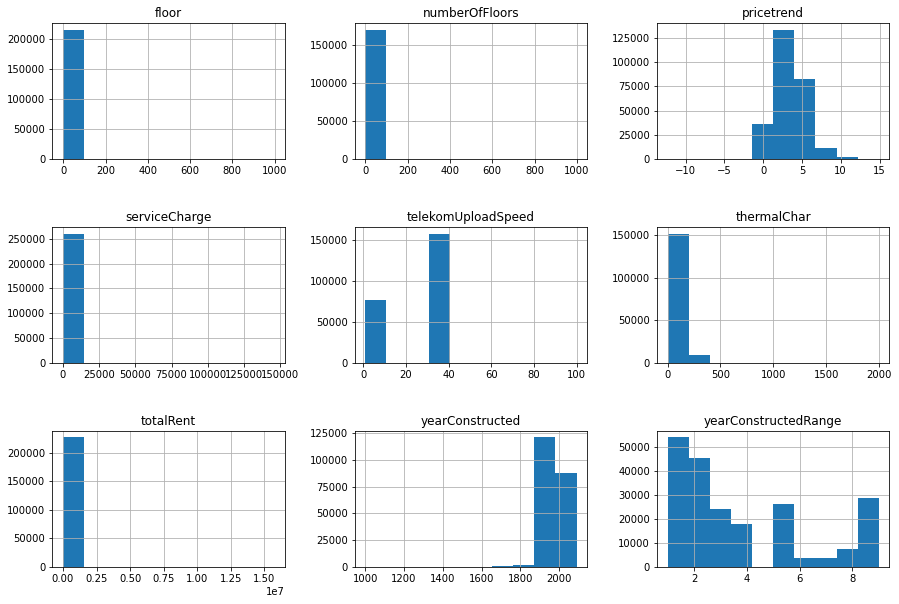

In [570]:
#Plot charts of these features
mssgNumeric.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5);
    

- numberOfFloors, serviceCharge, telekomUploadSpeed, thermalChar, totalRent and yearConstructed are skewed. Lets review for outliers. Once we deal with the outliers we can review the histogram shapes and if normally distributed may consider imputing missing values with averages.
- As mentioned we will drop the feature - floor

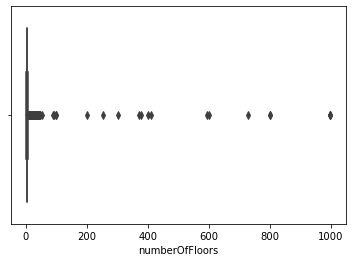

In [571]:
#Review numberOfFloors
_= sns.boxplot(x = 'numberOfFloors', data = rentals)

- The tallest building in Germany is the Commerzbank Tower in Frankfurt with 56 floors. We will review records that have number of floors greater than 56

In [572]:
many_floors = rentals[rentals.numberOfFloors > 56]

In [573]:
many_floors.shape

(19, 32)

In [581]:
many_floors.sort_values(by = 'numberOfFloors', ascending = False)

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,condition,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,date
48498,Bayern,120.0,central_heating,ONE_YEAR_FREE,False,True,11,4.31,40.0,720.0,1976.0,113684019,True,True,3.0,600.0,50.00,mint_condition,False,4,apartment,83346,2.0,NaN,1.0,999.0,2,False,2,Traunstein_Kreis,Bergen,2019-10-01
72253,Bayern,170.0,central_heating,ONE_YEAR_FREE,False,True,6,3.74,40.0,850.0,1985.0,111358313,False,True,4.0,680.0,69.00,mint_condition,False,5,ground_floor,83278,2.0,102.0,0.0,999.0,2,False,3,Traunstein_Kreis,Traunstein,2019-05-01
100789,Hessen,110.0,central_heating,ONE_YEAR_FREE,False,True,7,4.55,40.0,NaN,1973.0,115121989,True,False,3.0,300.0,27.00,well_kept,False,1,other,65549,1.0,118.2,1.0,999.0,1,False,1,Limburg_Weilburg_Kreis,Limburg_an_der_Lahn,2020-02-01
107377,Nordrhein_Westfalen,120.0,oil_heating,ONE_YEAR_FREE,False,True,1,3.60,2.4,680.0,NaN,115429800,True,True,NaN,560.0,75.00,NaN,False,4,roof_storey,42555,2.0,NaN,2.0,800.0,2,False,3,Mettmann_Kreis,Velbert,2020-02-01
181497,Nordrhein_Westfalen,140.0,gas_heating,ONE_YEAR_FREE,False,False,12,3.82,2.4,590.0,2000.0,113852687,True,True,5.0,450.0,73.00,well_kept,False,3,roof_storey,50189,3.0,NaN,2.0,800.0,3,False,3,Rhein_Erft_Kreis,Elsdorf,2019-10-01
262400,Nordrhein_Westfalen,178.0,central_heating,ONE_YEAR_FREE,False,True,14,4.35,10.0,908.0,1955.0,62930037,True,True,2.0,660.0,66.00,refurbished,True,5,apartment,47051,2.0,65.0,2.0,730.0,2,True,3,Duisburg,Altstadt,2018-09-01
150943,Nordrhein_Westfalen,210.0,central_heating,ONE_YEAR_FREE,False,True,9,3.80,40.0,NaN,1970.0,107373802,True,True,2.0,600.0,70.00,well_kept,True,4,apartment,41564,3.0,156.1,6.0,600.0,3,False,3,Neuss_Rhein_Kreis,Kaarst,2018-09-01
123333,Niedersachsen,110.0,central_heating,ONE_YEAR_FREE,False,True,17,5.08,40.0,NaN,1954.0,104361657,True,False,2.0,399.0,73.00,well_kept,True,2,apartment,26384,2.0,119.0,1.0,594.0,2,False,3,Wilhelmshaven,Heppens,2018-09-01
202923,Nordrhein_Westfalen,130.0,gas_heating,ONE_YEAR_FREE,False,False,9,2.54,40.0,540.0,NaN,113585371,False,False,NaN,410.0,74.00,NaN,False,3,roof_storey,42369,2.0,NaN,3.0,410.0,2,False,3,Wuppertal,Ronsdorf,2019-10-01
82112,Sachsen,120.0,central_heating,ONE_YEAR_FREE,False,True,11,1.37,40.0,4.0,1995.0,65507848,True,True,5.0,280.0,52.50,well_kept,True,1,apartment,1662,1.0,79.6,2.0,400.0,1,False,2,Meißen_Kreis,Meißen,2019-10-01


- There is no discernable pattern associated with why these records have high values for their numbers of floors. We will delete these records

In [575]:
#Remove records with high numberOfFloors
rentals = rentals[~(rentals.numberOfFloors > 56)]

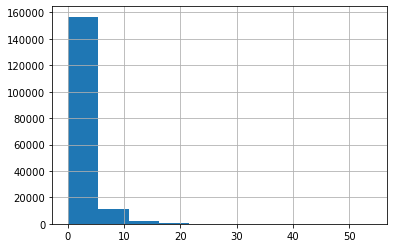

In [577]:
#Review numberOfFloors
_= rentals.numberOfFloors.hist()

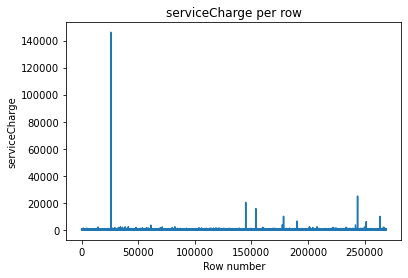

In [468]:
#Review serviceCharge
_= rentals.serviceCharge.plot()
_= plt.xlabel('Row number')
_= plt.ylabel('serviceCharge')
_= plt.title('serviceCharge per row')

- We notice an outlier for a value above 140,000 euros. This corresponds to the max value fo serviceCharge of 146,118. We should review the record before deletion. 

In [470]:
#Review row with containing a serviceCharge of 146,118 euros
rentals[rentals.serviceCharge == 146_118]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,condition,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,date
25687,Nordrhein_Westfalen,146118.0,self_contained_central_heating,NaN,False,False,6,4.74,NaN,794.29,1928.0,110967960,False,True,1.0,648.29,117.87,modernized,False,5,apartment,44809,3.0,147.0,1.0,NaN,3,False,5,Bochum,Hamme,2019-05-01


- We note that the totalRent is 794.29 euros and baseRent is 648.29 euros. It doesn't make sense for the serviceCharge to be 146,188 euros. We will remove this row and review the distibution of serviceCharge

In [474]:
#Select rows where serviceCharge is greater than totalRent
rentals.loc[(rentals.serviceCharge > rentals.totalRent) & (rentals.totalRent > 0),['serviceCharge','totalRent','baseRent']]



,serviceCharge,totalRent,baseRent
1311,1150.0,200.00,950.00
5885,730.0,130.00,600.00
24858,590.0,200.00,390.00
25687,146118.0,794.29,648.29
27086,1337.0,799.00,516.00
...,...,...,...
243082,152.0,1.00,459.00
243699,420.0,320.00,320.00
249171,1000.0,430.00,330.00
249754,150.0,1.30,960.00


- We observe that in some instances, the totalRent is 0. This maybe a typo because we also see positive values for baseRent. We will therefore not drop any more rows. 

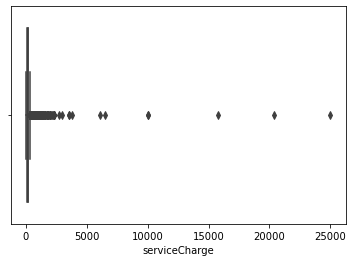

In [407]:
#Review serviceCharge
_= sns.boxplot(x = 'serviceCharge', data = rentals)

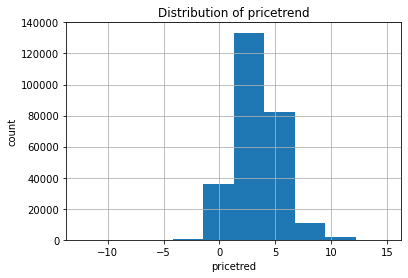

In [480]:
#Histogram of pricetrend
_= rentals.pricetrend.hist()
_= plt.xlabel('pricetred')
_= plt.ylabel('count')
_= plt.title('Distribution of pricetrend')


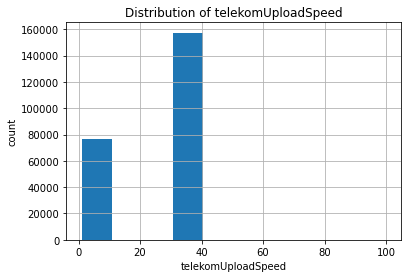

In [481]:
#Histogram of telekomUploadSpeed
_= rentals.telekomUploadSpeed.hist()
_= plt.xlabel('telekomUploadSpeed')
_= plt.ylabel('count')
_= plt.title('Distribution of telekomUploadSpeed')

In [ ]:
rentalsNum.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5)


We note the following information from the data owner:
- scoutId is an identifier for each rental listing. It has no relevance for analysis. This will be dropped.
- pricetrend is metric determined by the data owner. There is no visibility to what this means. This will be dropped.
- geo_plz should be an object because it is the zip code of each property
- noRoomsRange is the histogram bin number corresponding to the noRooms. This is additional information we do not need. This will be dropped.
- livngSpaceRange is the historgram bin number corresponding to livingSpace. This is additional information we do not need. This will be dropped.
- baseRentRange is the historgram bin number corresponding to baseRent. This is additional information we do not need. This will be dropped.

In [ ]:
rentalsNum.drop(columns = ['pricetrend','geo_plz','scoutId','noRoomsRange', 'livingSpaceRange', 'baseRentRange'], inplace = True)

In [ ]:
_= sns.boxplot(x = 'baseRent', data = rentalsNum)
#We observe high monthly rent rates, going to 10bln euros. For now, we will restrict max rent to 50,000 euros
# and min rent to 50 euros

In [ ]:
_= sns.boxplot(x = 'livingSpace', data = rentalsNum)  
#We observe units with large sizes. We will restrict the max unit area to 1000 sqm and min area to 10 sqm (parking lot). 

In [ ]:
_= sns.boxplot(x = 'noRooms', data = rentalsNum)
#We observe units with many rooms. For now, we will restrict max number of rooms to 100 and min number of rooms to 1. 

In [ ]:
_= sns.boxplot(x = 'picturecount', data = rentalsNum)
#We will restrict number of pictures to 50

In [ ]:
_= sns.boxplot(x = 'serviceCharge', data = rentalsNum)
#For now,we will restrict max serviceCharge to 10,000 euros

In [ ]:
_= sns.boxplot(x = 'telekomUploadSpeed', data = rentalsNum)

In [ ]:
#Adding the restrictions 
rent = (rentalsNum.baseRent > 50) & (rentalsNum.baseRent < 4000)
space = (rentalsNum.livingSpace > 10) & (rentalsNum.livingSpace < 300)
rooms = (rentalsNum.noRooms > 1) & (rentalsNum.noRooms < 10)
pictures = (rentalsNum.picturecount < 50)
charge = (rentalsNum.serviceCharge < 1000)
selectRows = rent & space & rooms & pictures & charge

In [ ]:
#Including only select rows in our numeric dataframe
rentalsNum = rentalsNum[selectRows]

In [ ]:
rentalsNum.hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5)

In [ ]:
#Including only select rows in our main dataframe
rentals = rentals[selectRows]

In [ ]:
#Dropping aforementioned columns
rentals.drop(columns = ['pricetrend','scoutId','noRoomsRange','livingSpaceRange', 'baseRentRange'], inplace = True)

In [ ]:
#Converting geo_plz to string
rentals['geo_plz'] = rentals['geo_plz'].astype(str)

In [ ]:
rentals.info()



In [ ]:
rentals.head()

In [ ]:
datapath = 'C:\\Users\\zebin\\OneDrive\\Documents\\Education\\Data Science\\Springboard - Data Science\\Capstones\\Capstone_2\\german_apartment_rentals\\data\\processed'
# renaming the output data directory and re-running this notebook, for example,
# will recreate this (empty) directory and resave the data files.
# NB this is not a substitute for a modern data pipeline, for which there are
# various tools. However, for our purposes here, and often in a "one off" analysis,
# this is useful because we have to deliberately move/delete our data in order
# to overwrite it.
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [ ]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)